In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
# Cargar datos
df0 = pd.read_csv('datos/gym_members_exercise_tracking.csv')
df0['Gender'] = df0['Gender'].replace({'Male': 0, 'Female': 1})
workout_dummies = pd.get_dummies(df0['Workout_Type'], prefix='Workout_Type')
df = pd.concat([df0, workout_dummies], axis=1)
df = df.drop('Workout_Type', axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_19160\491743272.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df0['Gender'] = df0['Gender'].replace({'Male': 0, 'Female': 1})


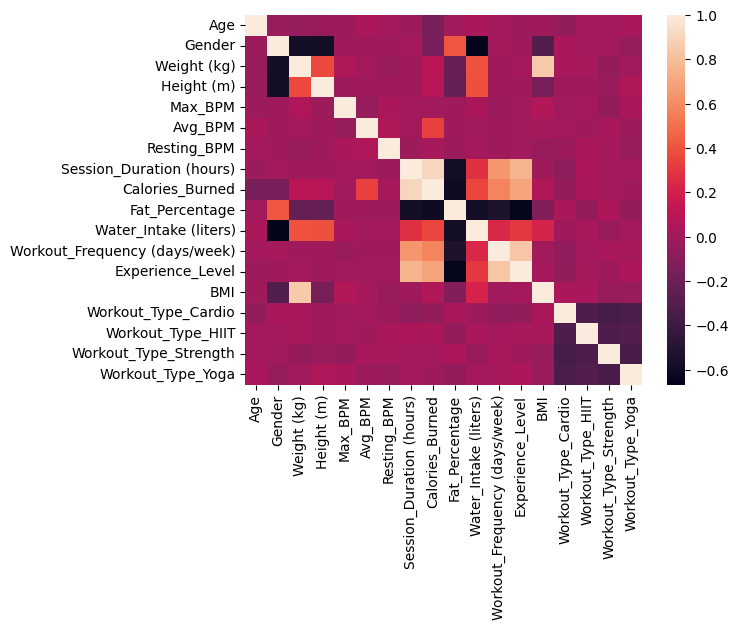

In [41]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False)
plt.show()

In [42]:
# Eliminar variables no útiles
df = df.drop('BMI', axis=1)
df = df.drop('Max_BPM', axis=1)
df = df.drop('Avg_BPM', axis=1)
df = df.drop('Resting_BPM', axis=1)

In [43]:
# Prueba de esfericidad de Bartlett
bartlett_test, p_value = calculate_bartlett_sphericity(df)
print(f"Test de Bartlett: {bartlett_test}, p-value: {p_value}")

Test de Bartlett: 40306.94178953657, p-value: 0.0


In [44]:
def calculate_kmo2(df, regularization=1e-10):
    # Step 1: Calculate the correlation matrix
    corr_matrix = df.corr()
    corr_squared = np.square(corr_matrix.values)  # Use .values to work with NumPy arrays
    
    # Step 2: Add small regularization to diagonal for invertibility
    corr_matrix += np.eye(corr_matrix.shape[0]) * regularization
    
    try:
        # Calculate the partial correlation matrix
        partial_corr_inv = np.linalg.inv(corr_matrix.values)  # Inverse of the correlation matrix
        partial_corr = -1 * (partial_corr_inv / np.sqrt(np.outer(np.diag(partial_corr_inv), np.diag(partial_corr_inv))))
        np.fill_diagonal(partial_corr, 1)  # Set diagonal elements to 1
        partial_corr_squared = np.square(partial_corr)
    except np.linalg.LinAlgError as e:
        raise ValueError(f"Matrix inversion failed. Check your data for singularity issues. Original error: {e}")
    
    # Step 3: Calculate the KMO for the entire dataset
    sum_corr_squared = np.sum(corr_squared) - np.trace(corr_squared)  # Exclude diagonal
    sum_partial_corr_squared = np.sum(partial_corr_squared) - np.trace(partial_corr_squared)  # Exclude diagonal
    kmo_total = sum_corr_squared / (sum_corr_squared + sum_partial_corr_squared)
    
    # Step 4: Calculate the KMO for each variable
    kmo_per_variable = []
    for i in range(df.shape[1]):
        sum_corr_squared_i = np.sum(corr_squared[:, i]) - corr_squared[i, i]  # Exclude diagonal
        sum_partial_corr_squared_i = np.sum(partial_corr_squared[:, i]) - partial_corr_squared[i, i]  # Exclude diagonal
        kmo_var = sum_corr_squared_i / (sum_corr_squared_i + sum_partial_corr_squared_i)
        kmo_per_variable.append(kmo_var)
    
    return kmo_total, kmo_per_variable

In [45]:
# Medida de adecuación KMO
kmo_total, kmo_per_variable = calculate_kmo2(df)
print(f"KMO: {kmo_total}")

KMO: 0.49193064788741825


In [46]:
# Realizar análisis factorial
fa = FactorAnalyzer(rotation=None)
fa.fit(df)

FactorAnalyzer(rotation=None, rotation_kwargs={})

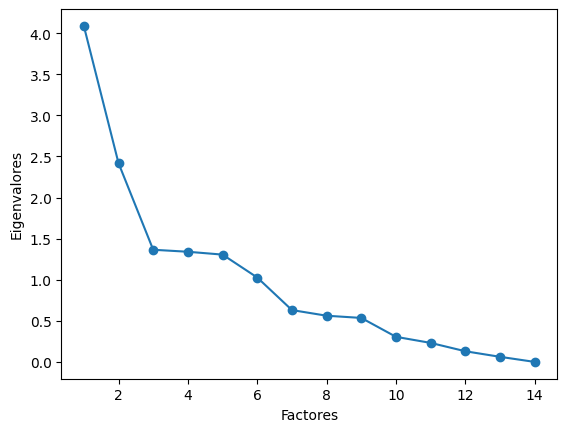

In [47]:
# Eigenvalores para determinar el número de factores
eigenvalues, _ = fa.get_eigenvalues()
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker="o")
#plt.title("Gráfico de scree")
plt.xlabel("Factores")
plt.ylabel("Eigenvalores")
plt.show()

In [48]:
# Ajustar modelo con 3 factores
fa = FactorAnalyzer(rotation='varimax', n_factors=3)
fa.fit(df)

FactorAnalyzer(rotation='varimax', rotation_kwargs={})

In [49]:
# Cargar factores
factor_loadings = pd.DataFrame(fa.loadings_, columns=['Factor1', 'Factor2','Factor3'], index=df.columns)
print(factor_loadings)

                                Factor1   Factor2   Factor3
Age                           -0.041643  0.008481  0.014072
Gender                         0.025147 -0.974287 -0.012231
Weight (kg)                   -0.019320  0.585904 -0.040423
Height (m)                    -0.023094  0.592848 -0.020041
Session_Duration (hours)       0.903517  0.012460  0.019557
Calories_Burned                0.828407  0.161715  0.023052
Fat_Percentage                -0.672982 -0.449072  0.034690
Water_Intake (liters)          0.317667  0.701280 -0.016464
Workout_Frequency (days/week)  0.781251 -0.000885  0.029672
Experience_Level               0.914076  0.025945  0.000349
Workout_Type_Cardio           -0.064056 -0.012219 -0.219027
Workout_Type_HIIT              0.048285 -0.003031 -0.178678
Workout_Type_Strength         -0.011253 -0.013032  1.035779
Workout_Type_Yoga              0.024160  0.035058 -0.194584


In [50]:
print(factor_loadings.to_latex())

\begin{tabular}{lrrr}
\toprule
 & Factor1 & Factor2 & Factor3 \\
\midrule
Age & -0.041643 & 0.008481 & 0.014072 \\
Gender & 0.025147 & -0.974287 & -0.012231 \\
Weight (kg) & -0.019320 & 0.585904 & -0.040423 \\
Height (m) & -0.023094 & 0.592848 & -0.020041 \\
Session_Duration (hours) & 0.903517 & 0.012460 & 0.019557 \\
Calories_Burned & 0.828407 & 0.161715 & 0.023052 \\
Fat_Percentage & -0.672982 & -0.449072 & 0.034690 \\
Water_Intake (liters) & 0.317667 & 0.701280 & -0.016464 \\
Workout_Frequency (days/week) & 0.781251 & -0.000885 & 0.029672 \\
Experience_Level & 0.914076 & 0.025945 & 0.000349 \\
Workout_Type_Cardio & -0.064056 & -0.012219 & -0.219027 \\
Workout_Type_HIIT & 0.048285 & -0.003031 & -0.178678 \\
Workout_Type_Strength & -0.011253 & -0.013032 & 1.035779 \\
Workout_Type_Yoga & 0.024160 & 0.035058 & -0.194584 \\
\bottomrule
\end{tabular}



In [51]:
# Varianza explicada
variance = pd.DataFrame({
    "Varianza explicada": fa.get_factor_variance()[0],
    "Varianza acumulada": fa.get_factor_variance()[2]
}, index=['Factor1', 'Factor2','Factor3'])
print(variance)

         Varianza explicada  Varianza acumulada
Factor1            3.512723            0.250909
Factor2            2.366059            0.419913
Factor3            1.196251            0.505359
